In [1]:
import matplotlib.pyplot as plt
# functions to plot grayscale and RGB images

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8), interpolation="nearest")
    plt.axis("off")

In [3]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220,130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width,1)

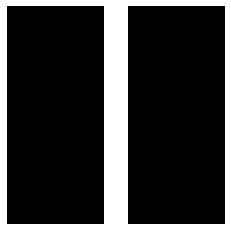

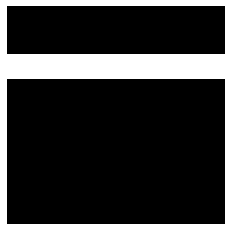

In [17]:
fmap = np.zeros(shape=(9,9,1,2), dtype=np.float32)
fmap[:,4,0,0] = 1
fmap[2,:,0,1] = 1
plot_image(fmap[:,:,0,0])
plt.show()
plot_image(fmap[:,:,0,1])
plt.show()


In [18]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=(None, height,width, 1))
print(height, width)
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps,strides=[1,1,1,1], padding="SAME")

70 120


In [19]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X:images})

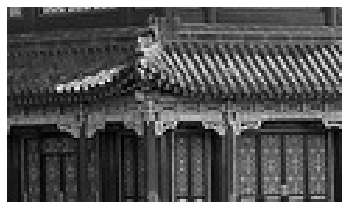

In [20]:
plot_image(images[0,:,:,0])
plt.show()

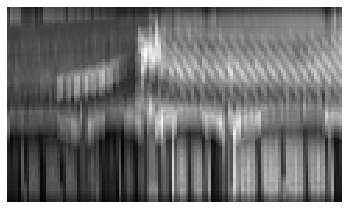

In [22]:
plot_image(output[0,:,:,0])
plt.show()

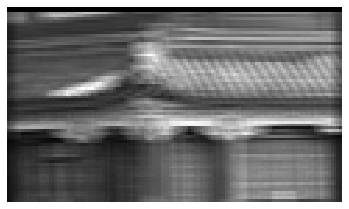

In [23]:
plot_image(output[0, :,:,1])
plt.show()

In [30]:
# tackling mnist
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fcl = 64
n_outputs = 10

tf.reset_default_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None,n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides= conv1_stride, padding=conv1_pad,
                         activation = tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation = tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fcl"):
    fcl = tf.layers.dense(pool3_flat, n_fcl, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fcl, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits,name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    

In [31]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28 * 28)/255.0
X_test = X_test.astype(np.float32).reshape(-1,28*28)/255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid ,X_train = X_train[:5000],X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [34]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        

In [35]:
n_epochs = 10
batch_size =100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        acc_batch = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        acc_test = accuracy.eval(feed_dict={X:X_test, y:y_test})
        print(epoch, acc_batch, acc_test)
        
        save_path = saver.save(sess, "./ageron_model")

0 0.96 0.9801
1 0.98 0.9837
2 0.99 0.9852
3 1.0 0.9832
4 0.97 0.9887
5 0.98 0.9866
6 1.0 0.9878
7 1.0 0.9848
8 1.0 0.9853
9 1.0 0.988


## Simple example

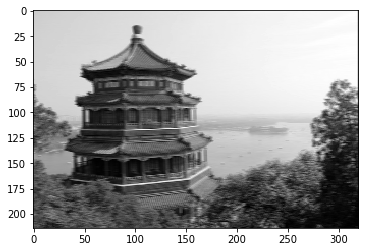

In [38]:
tf.reset_default_graph()

china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7,7, channels, 2), dtype=np.float32)
filters[:,3, :, 0]= 1
filters[3,:,:,1] = 1

X = tf.placeholder(tf.float32,shape=(None,height,width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1],padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X:dataset})

plt.imshow(output[0, :,:, 1], cmap="gray")
#[image, height,width, feature_map]
plt.show()

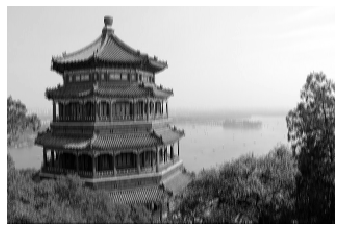

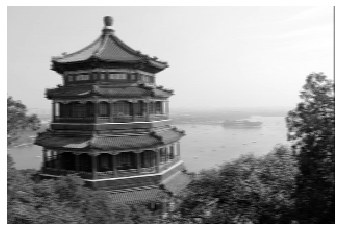

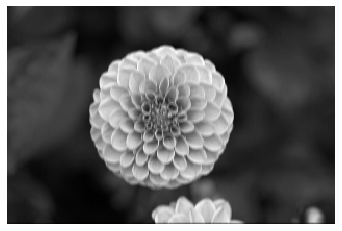

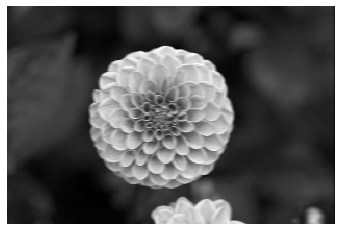

In [41]:
for image_index in (0,1):
    for feature_map_index in (0,1):
        plot_image(output[image_index, 5:,5:, feature_map_index])
        plt.show()

In [48]:
# using just numbers to initialise strides , filters and kernel size

X = tf.placeholder(shape=(None, height, width,channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=2, padding="SAME")

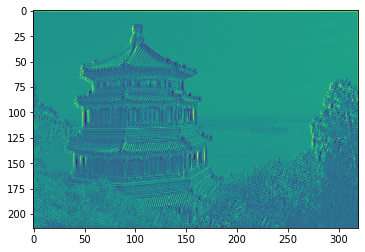

In [49]:
init =tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv,feed_dict={X:dataset})

plt.imshow(output[0,:,:,0])
plt.show()

In [51]:
## Validvs SAMe padding

filter_primes =np.array([2.,3.,5.,7.,11.,13.],dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1,1,13,1]))
filters = tf.constant(filter_primes.reshape(1,6,1,1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1,1,5,1],padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1,1,5,1], padding='SAME')

with tf.Session() as sess:
    print(valid_conv.eval())
    print(same_conv.eval())

[[[[184.]
   [389.]]]]
[[[[143.]
   [348.]
   [204.]]]]


In [52]:
# what happenedbehind the scenes
# for valid the filters we used in this format
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))

#for same these filters were used
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))


184.0
143.0
204.0


### Pooling layer

In [53]:
batch_size,height, width, channels = dataset.shape
print(dataset.shape)

(2, 427, 640, 3)


In [54]:
filters = np.zeros(shape=(7,7,channels,3), dtype=np.float32)
filters[:,3,:,0] = 1
filters[3,:,:,1] = 1

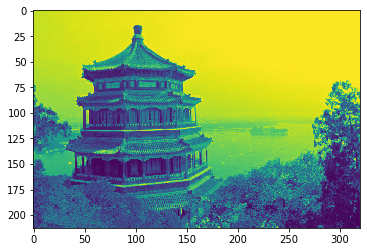

In [60]:
X = tf.placeholder(tf.float32, shape=(None, height,width,channels ))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X:dataset})

plt.imshow(output[0,:,:,2].astype(np.uint8))
plt.show()

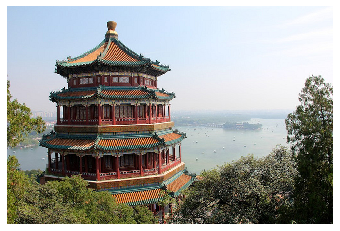

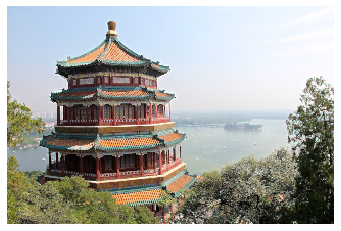

In [57]:
plot_color_image(dataset[0])
plt.show()

plot_color_image(output[0])
plt.show()